In [43]:
%load_ext autoreload
%autoreload 2
from src.models.representation.vae import *
from src.models.representation.vae.vae import RecurrentVaeWithTeacherForcing
from src.models.representation.vae.decoder.recurrent_decoder import *
from src.models.representation.vae.encoder.recurrent_encoder import *
from src.dataloader.dataset import PianoRollMidiDataset
pretty_int = lambda n: f"{n:,}".replace(",", " ")

def show_summary(model, input_shape=None, batch_size=None, dataset=None):
    """
    Show summary of the model.
    """
    print(model)
    p_count = sum(p.numel() for p in model.parameters())
    print(f"Model: {model.__class__.__name__}")
    
    print(f"Number of parameters: {pretty_int(p_count)}")
    print(f"Number of trainable parameters: {pretty_int(sum(p.numel() for p in model.parameters() if p.requires_grad))}")
    total_param_memory = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"Total parameter memory: {total_param_memory / (1024 ** 2):.2f} MB")
    if input_shape is not None:
        print(f"Input shape: {input_shape}")
    if batch_size is not None:
        print(f"Batch size: {batch_size}")
    if dataset is not None and input_shape is not None and batch_size is not None:
        print(f"Dataset size: {pretty_int(len(dataset))} samples")
        ratio = p_count / len(dataset)
        if p_count > len(dataset):
            print("Warning: Model has more parameters than samples in the dataset. This may lead to overfitting.")
        print(f"Parameter to sample ratio: {ratio:.2f}")
        


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pickle
from torchsummary import summary

import torch

dataset: PianoRollMidiDataset = pickle.load(open("data/preprocessed_note_events.pkl", "rb"))

print("Loaded dataset with", pretty_int(len(dataset)), "samples.")

Loaded dataset with 4 396 653 samples.


In [45]:
from torch.utils.data import DataLoader
from src.models.representation.vae.encoder.recurrent_encoder import LSTMVaeEncoderPitchEmbedding
from src.models.representation.vae.decoder.recurrent_decoder import LSTMVaeDecoderWithTeacherForcingPitchEmbedded
import torch
from src.models.representation.vae.vae_loss import VaeLossWithCrossEntropy
import torch_optimizer

LATENT_DIM = 1_024 # sequence length of 4, so we have 16 dimensions per step 
EPOCHS = 50
ENC_HIDDEN_DIM = 16 * 4
DEC_HIDDEN_DIM = 16 * 4
DEC_FC_OUTPUT = 32
ENC_DEC_LAYERS = 4
RUN_NAME = f"test/vae_8_BotB_beta_step0_01"


log_hyperparams = {
    "latent_dim": LATENT_DIM,
    "epochs": EPOCHS,
    "encoder_hidden_dim": ENC_HIDDEN_DIM,
    "decoder_hidden_dim": DEC_HIDDEN_DIM,
    "run_name": RUN_NAME,
}


encoder = LSTMVaeEncoderPitchEmbedding(
    4,
    ENC_HIDDEN_DIM,
    LATENT_DIM,
    ENC_DEC_LAYERS,
    linear_scaling_dim=4*3,
    pitch_embedding_dim=4,
    dropout=0.5,
)
decoder = LSTMVaeDecoderWithTeacherForcingPitchEmbeddedResidualMemory(
    LATENT_DIM, 
    DEC_HIDDEN_DIM,
    DEC_FC_OUTPUT,
    ENC_DEC_LAYERS,
    teacher_forcing_ratio=0.6,
    teacher_forcing_decrease=0.05
)

vae = RecurrentVaeWithTeacherForcing(encoder, decoder).cuda()

MAX_DELTA_TIME = 2 
MIN_NOTE_DURATION = 0.1
SEQUENCE_LENGTH = 4

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences in the batch.
    """
    batch = torch.stack(batch, dim=0)
    # batch = batch[:,:SEQUENCE_LENGTH,:]
    batch[:, :, 2:] = batch[:, :, 2:].clamp(min=MIN_NOTE_DURATION, max=MAX_DELTA_TIME)
    return batch

midi_dataloader = DataLoader(
    dataset,
    batch_size=4096,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn
)


optimizer = torch_optimizer.Lamb(
    vae.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

loss_fn = VaeLossWithCrossEntropy(
    reduction="mean",
    beta_max=1,
    beta_step=0.01,
)

trainer = VaeTrainer(
    vae,
    optimizer,
    loss_fn,
    RUN_NAME,
    40
)

t = next(iter(midi_dataloader))
show_summary(vae, input_shape=t[0].shape, batch_size=t.shape[0], dataset=dataset)


trainer.log_model_hyperparameters(log_hyperparams)
# trainer.graph_model(t.cuda())
with torch.no_grad():
    t_out = vae(t.cuda())
# print(f"Output shape: {t_out[0].shape}, {t_out[1].shape}")

RecurrentVaeWithTeacherForcing(
  (encoder): LSTMVaeEncoderPitchEmbedding(
    (linear): Linear(in_features=3, out_features=12, bias=True)
    (pitch_embedding): Embedding(128, 4)
    (lstm): LSTM(16, 64, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
    (mu_linear): Linear(in_features=128, out_features=1024, bias=True)
    (logvar_linear): Linear(in_features=128, out_features=1024, bias=True)
  )
  (decoder): LSTMVaeDecoderWithTeacherForcingPitchEmbeddedResidualMemory(
    (lstm): LSTM(131, 64, num_layers=32, batch_first=True)
    (latent_to_hidden): Linear(in_features=1024, out_features=64, bias=True)
    (latent_to_cell): Linear(in_features=1024, out_features=64, bias=True)
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (pitch_linear): Linear(in_features=4, out_features=128, bias=True)
    (other_scaling): Linear(in_features=4, out_features=3, bias=True)
  )
)
Model: RecurrentVaeWithTeacherForcing
Number of parameters: 1 819 078
Number of trai

In [46]:
ep = (t[2] * torch.tensor([1, 127, 1, 1]))

print(ep[0][0:2].long())

print("TIME ")
print(ep[0][2:])


tensor([43, 31])
TIME 
tensor([0.1000, 2.0000])


In [47]:
trainer.train(midi_dataloader, epochs=EPOCHS)


Epoch 36/50 - Loss: 16.7620:  72%|███████▏  | 36/50 [2:51:04<1:06:31, 285.14s/it]


KeyboardInterrupt: 

In [48]:
trainer.save_model(f"models/")
trainer.load_model(f"models/{RUN_NAME}.pth")

Saving model to models
Model saved to models/test/vae_8_BotB_beta_step0_01.pth
Loading model from models/test/vae_8_BotB_beta_step0_01.pth
Model loaded from models/test/vae_8_BotB_beta_step0_01.pth


100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


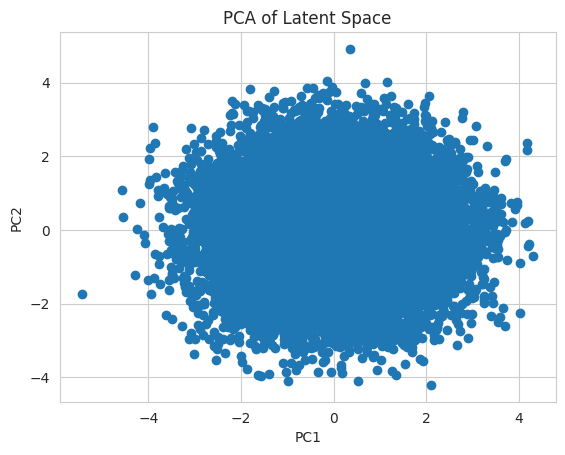

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm


vae.eval()

def disable_teacher_forcing(vae ):
    """
    Disable teacher forcing in the VAE model.
    """
    vae.decoder.teacher_forcing_ratio = 0
    vae.decoder.teacher_forcing_decrease = 0

@torch.inference_mode
def plot_pca(samples: list[tuple[torch.Tensor, torch.Tensor]]):
    all_latents = []
    for mu, logvar in samples:
        reparam = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
        all_latents.append(reparam.cpu().numpy())

    all_latents = np.concatenate(all_latents, axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_latents)

    plt.scatter(reduced[:, 0], reduced[:, 1])
    plt.title("PCA of Latent Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

vae.eval()
disable_teacher_forcing(vae)
eg_samples = []
for i in tqdm(range(5)):
    t = next(iter(midi_dataloader))
    mu, logvar = vae.encoder(t.cuda())
    eg_samples.append((mu, logvar))

plot_pca(eg_samples)

In [50]:
import pretty_midi

noise = torch.randn(1, LATENT_DIM).cuda()

@torch.inference_mode
def sampler(noise, sqe_length, vae: RecurrentVae):
    """
    Sample from the VAE using the provided noise.
    """
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio") is not None:
        vae.decoder.teacher_forcing_ratio = 0.0
    # Encode the noise
    # Decode to get the generated sequence
    d = vae.decoder(noise, seq_length=sqe_length)
    pitches_one_hot, others = d
    pitches = (torch.argmax(pitches_one_hot, dim=-1)).unsqueeze(-1)
    generated_sequence = torch.cat([pitches, others], dim=-1)
    return generated_sequence

@torch.inference_mode
def vae_adapter(x):
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio") is not None:
        vae.decoder.teacher_forcing_ratio = 0.0

    out, _, _ = vae(x.cuda())
    pitches_one_hot, others = out
    print(pitches_one_hot.shape, others.shape)
    print(pitches_one_hot.shape, others.shape)
    pitches = (torch.argmax(pitches_one_hot, dim=-1)).unsqueeze(-1)
    print(pitches.shape, others.shape)
    reconstruction = torch.cat([pitches, others], dim=-1)
    return reconstruction.cpu()
    

eg_track = sampler(noise, 32, vae)


In [51]:
def print_track_stats(track: torch.Tensor):
    """
    Print statistics of the track.
    """
    print(f"Track Shape: {track.shape}")
    pitches = track[:, 0].cpu().numpy()
    velocities = track[:, 1].cpu().numpy()
    time = track[:, 2].cpu().numpy()
    duration = track[:, 3].cpu().numpy()
    # pitches = pitches*127  # Scale pitches
    velocities = velocities*127  # Scale velocities
    print(f"Track Length: {len(track)}")
    print(f"Unique Pitches: {np.unique(pitches).size}")
    print(f"Unique Velocities: {np.unique(velocities).size}")
    print(f"max Pitch: {np.max(pitches)}")
    print(f"min Pitch: {np.min(pitches)}")
    print(f"max Velocity: {np.max(velocities)}")
    print(f"min Velocity: {np.min(velocities)}")
    print(f"Mean Pitch: {np.mean(pitches)}")
    print(f"Mean Velocity: {np.mean(velocities)}")
    duration_total = 0
    for i in range(1, len(duration)):
        duration_total += time[i] + duration[i]
    print(f"Total Duration: {duration_total}")
    


print_track_stats(eg_track[0])


Track Shape: torch.Size([32, 4])
Track Length: 32
Unique Pitches: 9
Unique Velocities: 32
max Pitch: 95.0
min Pitch: 48.0
max Velocity: 84.1617660522461
min Velocity: 64.92179870605469
Mean Pitch: 86.84375
Mean Velocity: 80.90614318847656
Total Duration: 12.808450698852539


In [52]:
print_track_stats(t[0])

Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 3
Unique Velocities: 6
max Pitch: 75.0
min Pitch: 59.0
max Velocity: 58.0
min Velocity: 49.0
Mean Pitch: 62.5
Mean Velocity: 54.875
Total Duration: 2.339583396911621


In [53]:
import pretty_midi

@torch.inference_mode
def note_events_to_pretty_midi(note_array, path="eg.mid", default_program=0):
    note_array = note_array.detach().cpu().numpy()
    #scale  and velocities
    note_array[:, 1] *= 127
    # clamp pitches and velocities
    note_array[:, 0] = np.clip(note_array[:, 0], 0, 127)
    note_array[:, 1] = np.clip(note_array[:, 1], 0, 127)
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=default_program)

    current_time = 0.0
    print(note_array.shape)
    for row in note_array:
        pitch, velocity, delta, duration = row
        current_time += delta
        start = current_time
        end = start + duration

        note = pretty_midi.Note(
            velocity=int(velocity),
            pitch=int(pitch),
            start=start,
            end=end
        )
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(path)


note_events_to_pretty_midi(eg_track[0], path="eg.mid")

(32, 4)


In [54]:

track_reco = vae_adapter(t[0].unsqueeze(0))
note_events_to_pretty_midi(track_reco[0], path="reco.mid")

torch.Size([1, 8, 128]) torch.Size([1, 8, 3])
torch.Size([1, 8, 128]) torch.Size([1, 8, 3])
torch.Size([1, 8, 1]) torch.Size([1, 8, 3])
(8, 4)


In [55]:
track_true = t[0]
note_events_to_pretty_midi(track_true, path="true.mid")

(8, 4)


(8, 4)


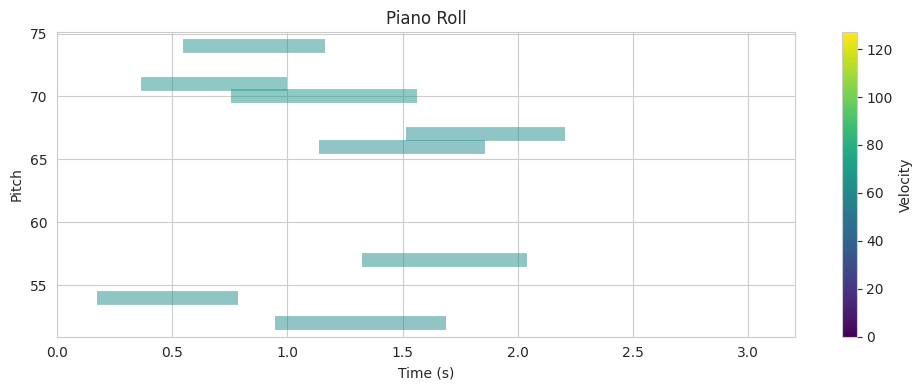

In [135]:
from matplotlib import cm
from matplotlib import colors as mcolors
import seaborn as sns
sns.set_style("whitegrid")

def plot_piano_roll(note_array, figsize=(10, 4)):
    if not isinstance(note_array, np.ndarray):
        note_array = note_array.detach().cpu().numpy()

    scaled_pitches = np.clip(note_array[:, 0], 0, 127).astype(np.int8)
    velocities = np.clip(note_array[:, 1] * 127, 0, 127).astype(np.int8)
    note_delta = note_array[:, 2]
    note_start = np.cumsum(note_delta)
    note_duration = note_array[:, 3]
    note_end = note_start + note_duration

    fig, ax = plt.subplots(figsize=figsize)

    # Normalize velocities for colormap
    norm = mcolors.Normalize(vmin=0, vmax=127)
    cmap = cm.viridis
    vel_color = cmap(norm(velocities))

    for i in range(len(note_start)):
        ax.hlines(scaled_pitches[i], note_start[i], note_end[i],
                  colors=vel_color[i], linewidth=10, alpha=0.5)

    # Add colorbar for velocity
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(velocities)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Velocity')

    ax.set_xlim(0, np.max(note_end) + 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch')
    ax.set_title('Piano Roll')
    fig.tight_layout()

noise = torch.randn(1, LATENT_DIM).cuda()
eg_track = sampler(noise, 8, vae)
plot_piano_roll(eg_track[0].detach().cpu().numpy())
note_events_to_pretty_midi(eg_track[0], path="eg_track.mid")

[0.16015625 0.26015624 0.4125     0.5125     0.6125     0.7375
 0.83750004 0.93750006]
[0.3203125  0.40729165 0.7171875  0.7286458  0.9197917  0.83750004
 1.2007813  1.061198  ]
[0.1380143  0.26680464 0.40567845 0.5375361  0.6838579  0.8151294
 0.95439404 1.0875773 ]
[0.42370498 0.521796   0.6958687  0.80943215 1.0569673  1.0838315
 1.2466666  1.3680723 ]


/tmp/ipykernel_461/2881521935.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


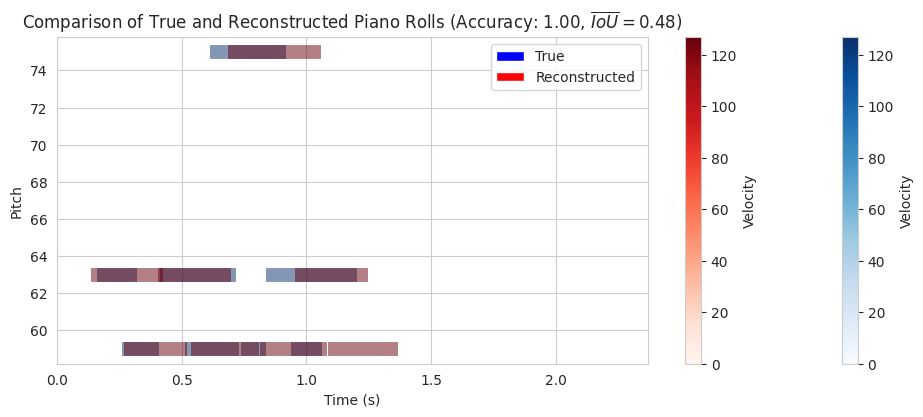

In [60]:
from matplotlib.patches import Patch


def plot_piano_roll_return(note_array, figsize=(10, 4), cmap='viridis', fig=None, ax=None, hide_colorbar=False):
    if not isinstance(note_array, np.ndarray):
        note_array = note_array.detach().cpu().numpy()

    scaled_pitches = np.clip(note_array[:, 0], 0, 127).astype(np.int8)
    velocities = np.clip(note_array[:, 1] * 127, 0, 127).astype(np.int8)
    note_delta = note_array[:, 2]
    note_start = np.cumsum(note_delta)
    note_duration = note_array[:, 3]
    note_end = note_start + note_duration

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Normalize velocities for colormap
    norm = mcolors.Normalize(vmin=0, vmax=127)
    cmap = cm.get_cmap(cmap)
    if cmap is None:
        cmap = cm.viridis
    vel_color = cmap(norm(velocities))

    for i in range(len(note_start)):
        ax.hlines(scaled_pitches[i], note_start[i], note_end[i],
                  colors=vel_color[i], linewidth=10, alpha=0.5)

    # Add colorbar for velocity
    if not hide_colorbar:
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(velocities)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Velocity')

    ax.set_xlim(0, np.max(note_end) + 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch')
    fig.tight_layout()




def iou_intervals(pred_start, pred_duration, target_start, target_duration):
    pred_end = pred_start + pred_duration
    target_end = target_start + target_duration
    
    inter_start = np.maximum(pred_start, target_start)
    inter_end = np.minimum(pred_end, target_end)
    intersection = np.maximum(0, inter_end - inter_start)

    union = np.maximum(pred_end, target_end) - np.minimum(pred_start, target_start)

    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.where(union > 0, intersection / union, 0.0)

    return iou

def unoffset_notes_start(notes: np.ndarray):
    """Unoffsets start time"""
    if isinstance(notes, torch.Tensor):
        notes = notes.detach().cpu().numpy()
    if notes.shape[1] < 4:
        raise ValueError("Notes must have at least 4 columns (pitch, start, duration, velocity)")
    
    unoffset_start = np.cumsum(notes[:, 2])
    unoffset_notes = np.copy(notes)
    unoffset_notes[:, 2] = unoffset_start
    return unoffset_notes

def pitch_match_accuracy_iou_ordered(pred_notes, target_notes, iou_threshold=0.1):
    if isinstance(pred_notes, torch.Tensor):
        pred_notes = pred_notes.detach().cpu().numpy()
    if isinstance(target_notes, torch.Tensor):
        target_notes = target_notes.detach().cpu().numpy()
    N_pred = pred_notes.shape[0]
    N_target = target_notes.shape[0]
    pred_notes = unoffset_notes_start(pred_notes)
    target_notes = unoffset_notes_start(target_notes)
    # Compare up to the min length (to avoid indexing errors)
    N = min(N_pred, N_target)
    
    pred_pitch = pred_notes[:N, 0]
    pred_start = pred_notes[:N, 2]
    pred_duration = pred_notes[:N, 3]
    
    target_pitch = target_notes[:N, 0]
    target_start = target_notes[:N, 2]
    target_duration = target_notes[:N, 3]

    pitch_matches = (pred_pitch == target_pitch)

    print(target_start)
    print(target_start + target_duration)
    print(pred_start)
    print(pred_start +  pred_duration)
    
    
    ious = iou_intervals(pred_start, pred_duration, target_start, target_duration)

    
    # Match if pitch matches and IoU above threshold
    # TODO: change matches to mAP
    matches = pitch_matches & (ious >= iou_threshold)
    
    accuracy = pitch_matches.sum() / N if N > 0 else 0.0
    return accuracy, ious, matches


def compare_reco_true(true, reco, figsize=(10, 4), threshold=0.5):
    fig, ax = plt.subplots(1, 1, figsize=figsize, sharex=True)
    plot_piano_roll_return(true, figsize=figsize, fig=fig, ax=ax, cmap='Blues')
    plot_piano_roll_return(reco, figsize=figsize, fig=fig, ax=ax, cmap='Reds')

    acc, iou, _ = pitch_match_accuracy_iou_ordered(
        reco, true, iou_threshold=threshold
    )
    ax.set_title('Comparison of True and Reconstructed Piano Rolls (Accuracy: {:.2f}, $\\overline{{IoU}} = {:.2f}$)'.format(acc, iou.mean()))
    legend_elements = [
        Patch(facecolor='blue', label='True'),
        Patch(facecolor='red', label='Reconstructed'),
    ]
    plt.legend(handles=legend_elements)
    plt.show()


compare_reco_true(
    track_true,
    track_reco.squeeze(0).detach().cpu().numpy(),
    figsize=(10, 4)
)



In [61]:
track_reco

tensor([[[63.0000, 68.0495,  0.1380,  0.2857],
         [59.0000, 65.5038,  0.1288,  0.2550],
         [63.0000, 67.8991,  0.1389,  0.2902],
         [59.0000, 65.2013,  0.1319,  0.2719],
         [75.0000, 75.6646,  0.1463,  0.3731],
         [59.0000, 65.2002,  0.1313,  0.2687],
         [63.0000, 67.9305,  0.1393,  0.2923],
         [59.0000, 64.9437,  0.1332,  0.2805]]])

In [63]:

example_for_reco = next(iter(midi_dataloader))[0].cuda()

def disable_teacher_forcing(vae: RecurrentVaeWithTeacherForcing):
    """
    Disable teacher forcing in the VAE.
    """
    vae.decoder.teacher_forcing_ratio = 0.0

disable_teacher_forcing(vae)



reco_track = vae_adapter(example_for_reco.unsqueeze(0)).squeeze(0)
print("----------")
print("Reconstructed Track Stats:")
print_track_stats(reco_track)
print("----------")
print("True Track Stats:")
print_track_stats(example_for_reco)


torch.Size([1, 8, 128]) torch.Size([1, 8, 3])
torch.Size([1, 8, 128]) torch.Size([1, 8, 3])
torch.Size([1, 8, 1]) torch.Size([1, 8, 3])
----------
Reconstructed Track Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 8
Unique Velocities: 8
max Pitch: 81.0
min Pitch: 43.0
max Velocity: 72.0255355834961
min Velocity: 62.24971389770508
Mean Pitch: 60.5
Mean Velocity: 65.12013244628906
Total Duration: 5.372347831726074
----------
True Track Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 8
Unique Velocities: 7
max Pitch: 81.0
min Pitch: 41.0
max Velocity: 86.0
min Velocity: 49.0
Mean Pitch: 57.75
Mean Velocity: 68.875
Total Duration: 6.543749809265137


[0.16666667 0.48046875 0.5804688  1.1664063  1.4072917  1.5072917
 1.8484375  2.10625   ]
[0.6822917 0.6822917 0.7875    2.1625    2.7328124 2.2820313 2.2065105
 2.8471355]
[0.17108807 0.3361048  0.51106083 0.693105   0.8740492  1.04772
 1.232933   1.4109957 ]
[0.6996126  0.86307293 1.0867707  1.3223386  1.4598179  1.6029875
 1.8396586  2.0637624 ]


/tmp/ipykernel_461/2881521935.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


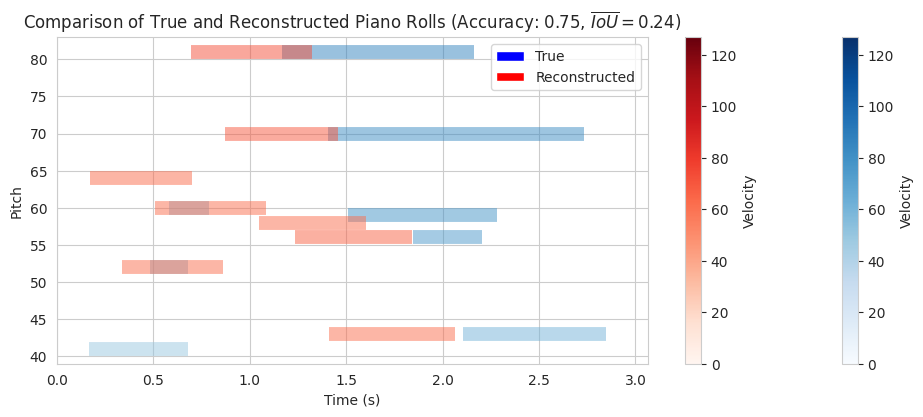

In [67]:
compare_reco_true(example_for_reco.detach().cpu().numpy(), reco_track, figsize=(10, 4))

torch.Size([1, 8, 128]) torch.Size([1, 8, 3])
torch.Size([1, 8, 128]) torch.Size([1, 8, 3])
torch.Size([1, 8, 1]) torch.Size([1, 8, 3])
[0.3216146  0.63151044 0.9609375  1.0208334  1.108073   1.108073
 1.1093751  1.4882814 ]
[2.0247395 1.4739584 3.3046875 2.623698  1.3346355 4.484375  4.451823
 4.123698 ]
[0.27447522 0.54671586 0.816569   1.0813308  1.3629838  1.6220014
 1.8931017  2.1720839 ]
[1.6326066 1.8927456 2.2231236 2.5235527 2.8300643 3.0879152 3.2901695
 3.5815446]


/tmp/ipykernel_461/2881521935.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


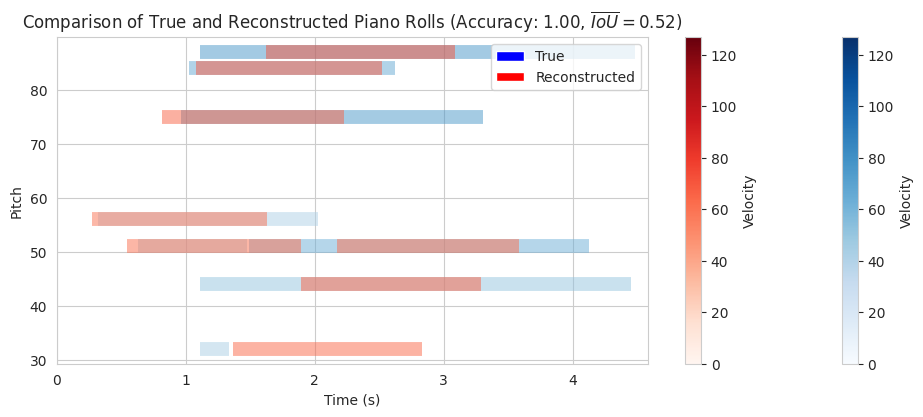

In [108]:

@torch.inference_mode
def get_random_pair(vae, dataloader, strip_to_seq_length=None):
    dataset = dataloader.dataset
    idx = np.random.randint(0, len(dataset), size=2)
        
    first_sample = dataset[idx[0]]
    reconstructed_sample = vae_adapter(first_sample.unsqueeze(0)).squeeze(0)
    if strip_to_seq_length is not None:
        first_sample = first_sample[:strip_to_seq_length, :]
        reconstructed_sample = reconstructed_sample[:strip_to_seq_length, :]
    
    return first_sample, reconstructed_sample.detach().cpu().numpy()


compare_reco_true(*get_random_pair(vae, midi_dataloader, strip_to_seq_length=8), figsize=(10, 4))

In [109]:
def get_by_idx(dataloader, idx):
    """
    Get a sample from the dataloader by index.
    """
    for i, batch in enumerate(dataloader):
        if i == idx:
            return batch


tracks = get_by_idx(midi_dataloader, 0)
print(f"Number of tracks: {tracks.shape[0]}")
for i,t in enumerate(tracks):
    print("----------")
    print(f"Track {i+1} Stats:")
    print_track_stats(t)

Number of tracks: 4096
----------
Track 1 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 8
Unique Velocities: 8
max Pitch: 88.0
min Pitch: 62.0
max Velocity: 87.0
min Velocity: 26.0
Mean Pitch: 73.75
Mean Velocity: 60.875
Total Duration: 5.713281154632568
----------
Track 2 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 8
Unique Velocities: 8
max Pitch: 69.0
min Pitch: 45.0
max Velocity: 67.0
min Velocity: 37.0
Mean Pitch: 59.0
Mean Velocity: 55.0
Total Duration: 8.993489265441895
----------
Track 3 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 7
Unique Velocities: 8
max Pitch: 73.0
min Pitch: 44.0
max Velocity: 66.0
min Velocity: 44.0
Mean Pitch: 60.25
Mean Velocity: 53.375
Total Duration: 2.801041603088379
----------
Track 4 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 6
Unique Velocities: 6
max Pitch: 77.0
min Pitch: 48.0
max Velocity: 74.0
min Velocity: 33.0
Mean Pitch: 67.5
Mean Velo

In [110]:
eg_batch = next(iter(midi_dataloader)).cuda()
print(f"Batch shape: {eg_batch.shape}")

target = eg_batch[:, :, 0].long().cuda()
print(f"Target shape: {target.shape}")

ce_loss_fn = torch.nn.CrossEntropyLoss(reduction='none')



Batch shape: torch.Size([4096, 8, 4])
Target shape: torch.Size([4096, 8])


In [114]:
def interpolate_latents(vae, noise1, noise2, steps=10, seq_length=16):
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio") is not None:
        vae.decoder.teacher_forcing_ratio = 0.0

    decoded = []
    noise1 = noise1.cuda()
    noise2 = noise2.cuda()
    for i in range(steps):
        alpha = i / (steps - 1)
        noise = noise1 * (1 - alpha) + noise2 * alpha
        track = sampler(noise, seq_length, vae)
        decoded.append(track)
    return decoded



def plot_interpolated_tracks(vae, latent_1, latent_2, steps=10, figsize=(10, 4), seq_len=8):

    events = interpolate_latents(vae, latent_1, latent_2, steps=steps, seq_length=seq_len)
    fig, axs = plt.subplots(len(events), 1, figsize=figsize, sharex=True, sharey=True)
    
    for ax, event in zip(axs, events):
        plot_piano_roll_return(event[0].detach().cpu().numpy(), figsize=figsize, fig=fig, ax=ax, cmap='Blues', hide_colorbar=True)
        ax.set_title(f"Step {len(axs) - np.where(axs == ax)[0][0] - 1}")
    plt.suptitle("Interpolated Tracks")
    
    

    plt.tight_layout()
    plt.show()


@torch.inference_mode
def get_best_reconstruction(vae, dataloader):
    best_reco = None
    best_latent = None
    best_loss = float('inf')
    loss_in_fn = VaeLossWithCrossEntropy(reduction="mean", beta=1)
    for x in tqdm(dataloader, desc="Finding best reconstruction"):
        x = x.cuda()
        reco, mu, logvar = vae(x)
        loss = loss_in_fn(reco, x, mu, logvar)[0]
        if loss < best_loss:
            best_loss = loss
            best_reco = reco
            best_latent = vae.encoder(x)[0]
            
    print(f"Best reconstruction loss: {best_loss.item()}")
    return best_reco, best_latent

noise1 = torch.randn(1, LATENT_DIM).cuda()
noise2 = torch.randn(1, LATENT_DIM).cuda()



/tmp/ipykernel_461/2881521935.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


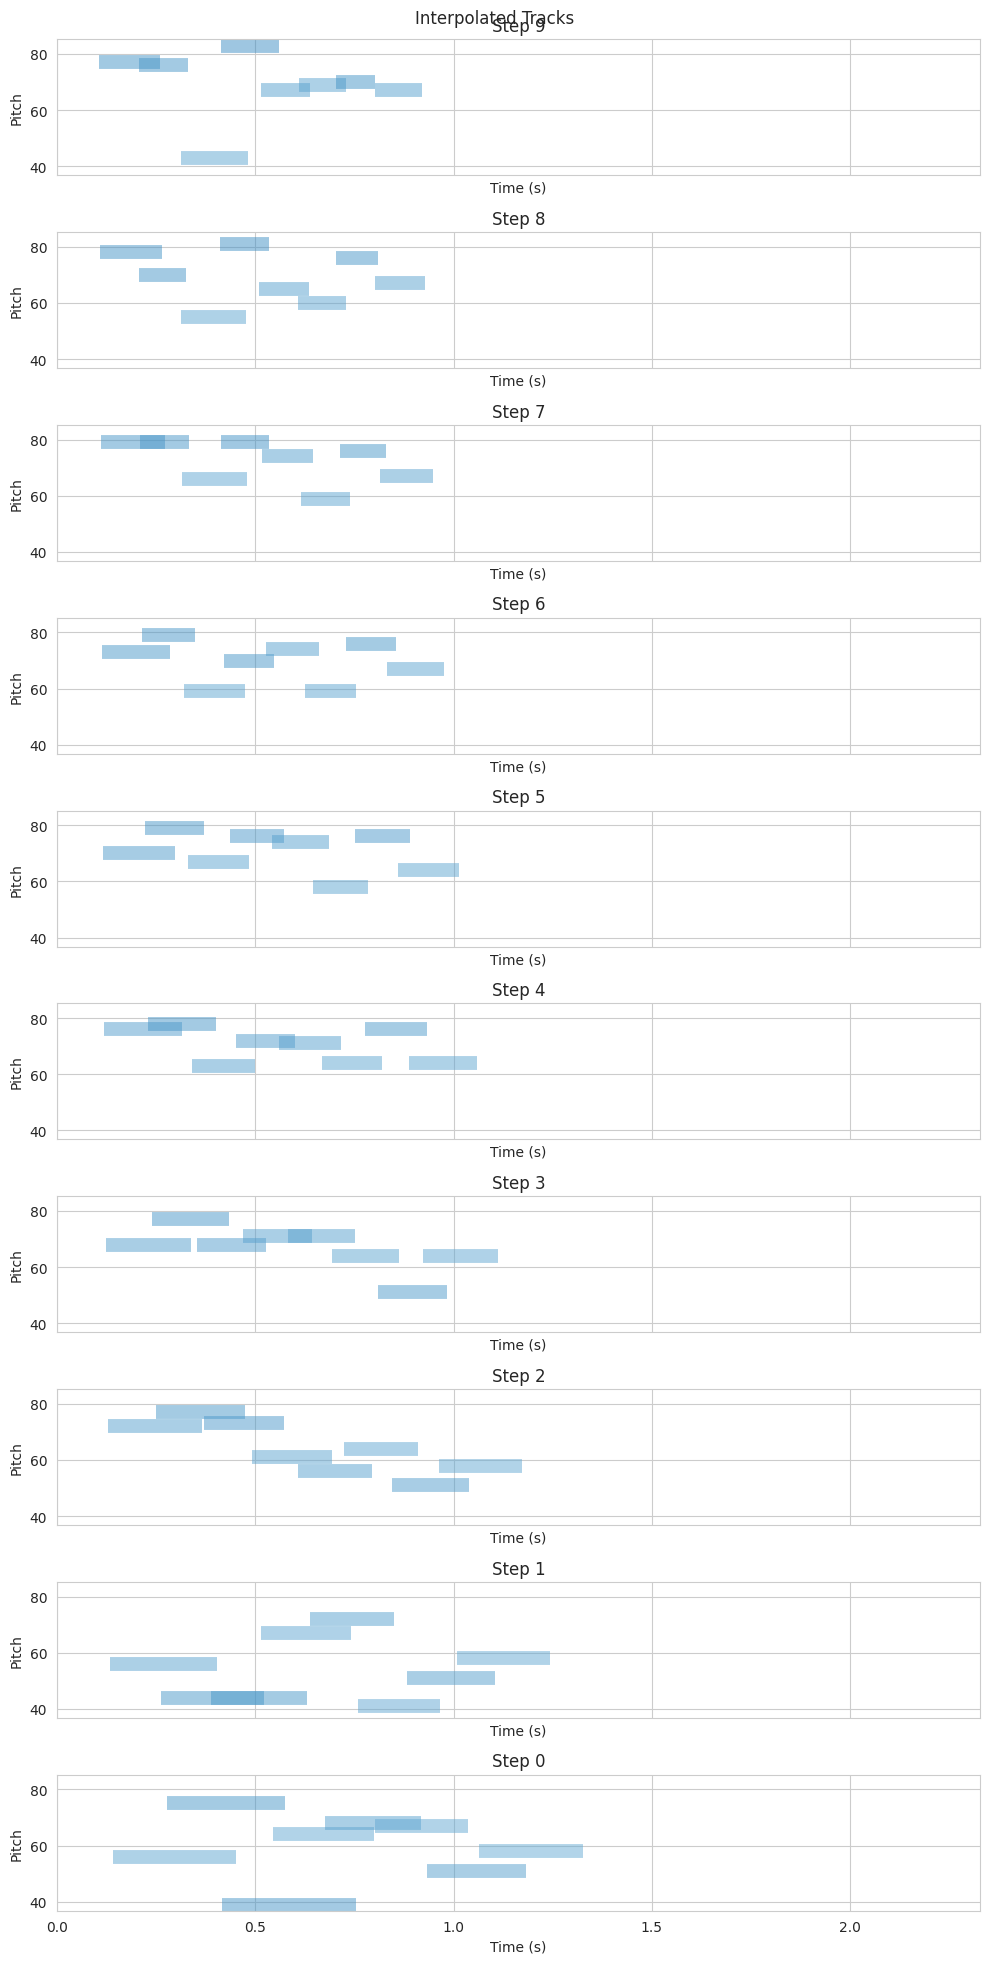

In [115]:
plot_interpolated_tracks(vae, noise2, noise1, steps=10, figsize=(10, 20))